## Регрессия на imdb

In [65]:
# ячейка импортов
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
import scipy
import pingouin as pg
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('IMDB-Movie-Data.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rank                1000 non-null   int64  
 1   Title               1000 non-null   object 
 2   Genre               1000 non-null   object 
 3   Description         1000 non-null   object 
 4   Director            1000 non-null   object 
 5   Actors              1000 non-null   object 
 6   Year                1000 non-null   int64  
 7   Runtime (Minutes)   1000 non-null   int64  
 8   Rating              1000 non-null   float64
 9   Votes               1000 non-null   int64  
 10  Revenue (Millions)  872 non-null    float64
 11  Metascore           936 non-null    float64
dtypes: float64(3), int64(4), object(5)
memory usage: 93.9+ KB


## Регрессии:

В этом датасете для регрессии есть несколько опций, выбирайте то, что более интересно: 

- определить рейтинг по описанию фильма
- определить длительность фильма по году создания
- определить рейтинг по длине фильма
- Ваша идея

Шаги выполнения: 
- Определите, какие части датасета необходимы для вашей задачи
- Если работаете с текстовыми ячейками, векторизуйте тексты
- Разделите данные на обучающую и тестовую выборку
- Попробуйте обучить [разные регрессионные модели](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) (не забудьте импортировать их в эту тетрадку)

- Для каждой модели посмотрите на метрики. 

Какая/какие модель/ли справляются с выбранной Вами задачей наиболее эффективно?

In [47]:
# колонки для предсказания; попробуем предсказать оценку фильма по выручке и оценке критиков.
data_learn = data[['Metascore', 'Revenue (Millions)', 'Rating']]

In [48]:
data_learn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Metascore           936 non-null    float64
 1   Revenue (Millions)  872 non-null    float64
 2   Rating              1000 non-null   float64
dtypes: float64(3)
memory usage: 23.6 KB


Есть пустые значения, надо убрать строки с ними.

In [49]:
data_learn = data_learn.dropna()

In [50]:
data_learn.describe()

,Metascore,Revenue (Millions),Rating
count,838.000000,838.000000,838.000000
mean,59.575179,84.564558,6.814320
std,16.952416,104.520227,0.877754
min,11.000000,0.000000,1.900000
25%,47.000000,13.967500,6.300000
50%,60.000000,48.150000,6.900000
75%,72.000000,116.800000,7.500000
max,100.000000,936.630000,9.000000


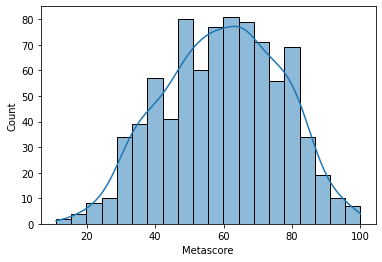

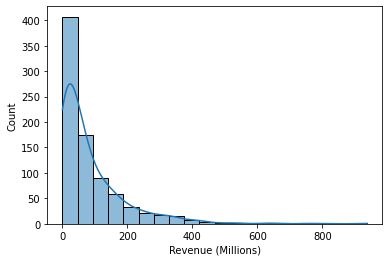

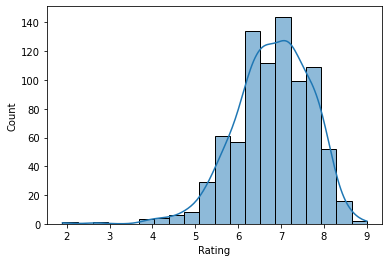

In [79]:
for column in data_learn.columns:
    plt.figure()             
    sns.histplot(data_learn[column], bins=20, kde=True)

Рейтинг и метаоценки распределены близко к нормальному, доход - логнормально.

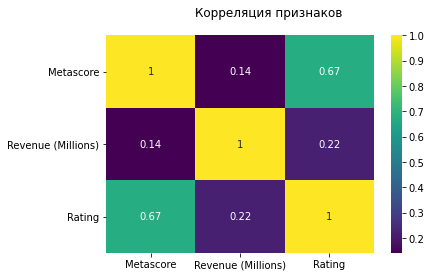

In [52]:
sns.heatmap(data=data_learn.corr(), annot=True, cmap= "viridis") 

plt.suptitle("Корреляция признаков")
plt.show()

Больше всего коррелирует с ретингом метаоценка. Можно посмотреть на график с регрессионной прямой.  

In [83]:
slope, intercept, r, p, stderr = scipy.stats.linregress(data_learn['Metascore'], data_learn['Rating'])
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

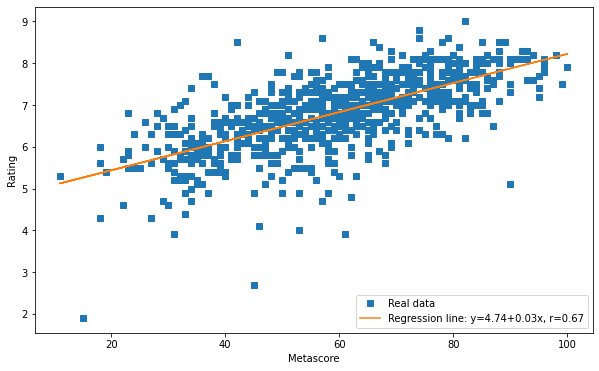

In [84]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data_learn['Metascore'], data_learn['Rating'], linewidth=0, marker='s', label='Real data')
ax.plot(data_learn['Metascore'], intercept + slope * data_learn['Metascore'], label=line)
ax.set_xlabel('Metascore')
ax.set_ylabel('Rating')
ax.legend(facecolor='white')
plt.show()

In [53]:
pairwise = data_learn.pairwise_corr(method='spearman',
                                         padjust='holm')
pairwise.round(3)

,X,Y,method,tail,n,r,CI95%,p-unc,p-corr,p-adjust,power
0,Metascore,Revenue (Millions),spearman,two-sided,838,0.054,"[-0.01, 0.12]",0.119,0.119,holm,0.344
1,Metascore,Rating,spearman,two-sided,838,0.698,"[0.66, 0.73]",0.000,0.000,holm,1.000
2,Revenue (Millions),Rating,spearman,two-sided,838,0.155,"[0.09, 0.22]",0.000,0.000,holm,0.995


In [64]:
vif_data = pd.DataFrame()
vif_data["feature"] = data_learn[['Revenue (Millions)', 'Metascore']].columns
vif_data["VIF"] = [variance_inflation_factor(data_learn[['Revenue (Millions)', 'Metascore']].values, i)
                          for i in range(len(data_learn[['Revenue (Millions)', 'Metascore']].columns))]
  
vif_data

,feature,VIF
0,Revenue (Millions),1.677424
1,Metascore,1.677424


p-value для пар metascore-rating и revenue-rating ниже уровня альфа, значит, корреляция является статистически значимой, а предикторы между собой значимо не коррелируют. Соблюдается допущение линейной регрессии о не мультиколлинеарности.

In [80]:
X = data_learn[['Revenue (Millions)', 'Metascore']].values
y = data_learn['Rating'].values

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [41]:
regressor_ridge = Ridge(alpha=0.01)
regressor_ridge.fit(X_train, y_train)
preds = regressor_ridge.predict(X_test)

print(mean_absolute_error(y_test, preds))
print(mean_squared_error(y_test, preds))
print(r2_score(y_test, preds))

0.4768444334507103
0.4576751423229662
0.4999907403609255


In [42]:
regressor_lasso = Lasso(alpha=0.001)
regressor_lasso.fit(X_train, y_train)
preds = regressor_lasso.predict(X_test)


print(mean_absolute_error(y_test, preds))
print(r2_score(y_test, preds))

0.4768468304215806
0.4999780701688322


In [43]:
regressor_net = ElasticNet(alpha=0.001)
regressor_net.fit(X_train, y_train)
preds = regressor_net.predict(X_test)


print(mean_absolute_error(y_test, preds))
print(r2_score(y_test, preds))

0.4768456628294899
0.4999842273589915


In [44]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)


print(mean_absolute_error(y_test, preds))
print(r2_score(y_test, preds))

0.47684443233353657
0.49999074652620346


#### Все регрессоры дали примерно одинаковый результат

In [46]:
# фильм, которого нет в датасете
regressor.predict(np.array([41, 44]).reshape(1, -1))

array([6.2716142])

![пример](img.png)